In [9]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp
import sympy


import holodeck as holo
import holodeck.single_sources as ss
from holodeck.constants import YR, MSOL
from holodeck import utils, plot, detstats

import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky
import hasasia as has

# 1 Setup
## 1.1 Strain Model

Build SAM and calculate strains

Make the semi-analytic model object.

In [10]:
dur = 10.0*YR
cad = 0.2*YR
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
sam = holo.sam.Semi_Analytic_Model() 
# sam = holo.sam.Semi_Analytic_Model(mtot=(1.0e4*MSOL, 1.0e11*MSOL, 20), mrat=(1e-3, 1.0, 20), redz=(1e-3, 10.0, 20))  # faster version
hard = holo.hardening.Hard_GW

Calculate strains. Single loudest only

In [11]:
fobs_orb_edges = fobs_edges / 2.0 
fobs_orb_cents = fobs/ 2.0
# edges
edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fobs_orb_cents) # should the zero stalled option be part of the parameter space?
edges[-1] = fobs_orb_edges
dfobs = np.diff(edges[-1])

# integrate for number
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges)) 
hc_ss, hc_bg = ss.ss_gws(edges, number, realize=30, 
                                        loudest = 1, params = False)  # just single loudest
print(hc_ss.shape)

12:26:48 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
12:26:48 INFO : Stalled SAM bins based on GMT: 1.98e+05/4.99e+05 = 3.96e-01 [sam.py:static_binary_density]
12:26:49 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
12:26:49 INFO : 	dens bef: (1.28e-114, 5.22e-53, 2.59e-13, 2.12e-03, 1.66e-02, 2.92e-02, 4.47e-02) [sam.py:static_binary_density]
12:26:55 INFO : Scatter added after 6.408771 sec [sam.py:static_binary_density]
12:26:55 INFO : 	dens aft: (6.14e-17, 7.92e-09, 2.90e-06, 2.19e-03, 1.69e-02, 2.92e-02, 4.27e-02) [sam.py:static_binary_density]
12:26:55 INFO : 	mass: 8.56e-02 ==> 8.54e-02 || change = -1.8507e-03 [sam.py:static_binary_density]
12:26:55 INFO : zeroing out 1.98e+05/4.99e+05 = 3.96e-01 systems stalled from GMT [sam.py:static_binary_density]
12:26:55 INFO : fraction of coalesced binaries: 4.33e+05/1.25e+07 = 3.47e-02 [sam.py:dynamic_binary_number]
12:26:55 INFO : stalled binaries are not being accounted for in

## 1.2 Place Binaries Randomly

(20, 25, 1)


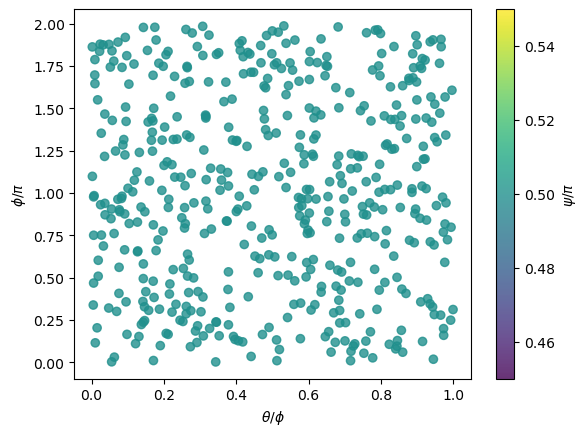

In [12]:
S = 20 # Sky Realizations
F = len(hc_ss) # Frequencies
R = len(hc_ss[0]) # Strain Realizations
L = len(hc_ss[0,0]) # Loudest

# shape (S,F,L)
theta_ss = np.random.uniform(0, np.pi, size = S*F*L).reshape(S,F,L)
phi_ss = np.random.uniform(0, 2*np.pi, size = S*F*L).reshape(S,F,L)
iota_ss = np.random.uniform(0, np.pi, size = S*F*L).reshape(S,F,L)
psi_ss = np.ones_like(theta_ss)*(np.pi/2)
# psi_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape) 
psi_label = 'psi = pi/2'
Phi0_ss = np.random.uniform(0, 2*np.pi, size = S*F*L).reshape(S,F,L)

print(theta_ss.shape)
plt.scatter(theta_ss/np.pi, phi_ss/np.pi, c=psi_ss/np.pi, cmap='viridis', alpha=0.8)
plt.xlabel(r'$\theta/\phi$')
plt.ylabel('$\phi/\pi$')
plt.colorbar(label=r'$\psi/\pi$ ')

## 1.3 Pulsar Setup

place 40 random pulsars

In [13]:
npsrs = 40
phis = np.random.uniform(0, 2*np.pi, size = npsrs)
thetas = np.random.uniform(np.pi/2, np.pi/2, size = npsrs)
sigmas = np.ones_like(phis)*1e-7

# build sim_pta
pulsars = hsim.sim_pta(timespan=dur/YR, cad=1/(cad/YR), sigma=sigmas,
                    phi=phis, theta=thetas)
# get spectrum for each
spectra = np.empty_like(pulsars, dtype=hsen.Spectrum)
for ii in range(npsrs):
    spectra[ii] = hsen.Spectrum(pulsars[ii], freqs=fobs)
    spectra[ii].NcalInv # calculate inverse noise weighted transmission function
# get sensitivity curve
scDeter = hsen.DeterSensitivityCurve(list(spectra))
skymap = np.empty(S, dtype=hsky.SkySensitivity) # one for each sky realization
for ss in range(S):
    skymap[ss] = hsky.SkySensitivity(list(spectra), theta_gw=theta_ss[ss,:,0], 
                                phi_gw=phi_ss[ss,:,0],
                                iota=iota_ss[ss,:,0], psi=psi_ss[ss,:,0]) #using 0th loudest

# 2 Calculate SNRs and DPs

In [14]:
dp_ros = np.zeros((S, R))
snr_ros = np.zeros((S, F, R, L))
dp_sky = np.zeros((S, R))
snr_sky = np.zeros((S, F, R, L))
for ss in range(S):
    theta_cur=theta_ss[ss,:,0][:,np.newaxis,np.newaxis] #(F,R,L), R=1
    phi_cur=phi_ss[ss,:,0][:,np.newaxis,np.newaxis] #(F,R,L), R=1
    iota_cur=iota_ss[ss,:,0][:,np.newaxis,np.newaxis] #(F,R,L), R=1
    Phi0_cur=Phi0_ss[ss,:,0][:,np.newaxis,np.newaxis] #(F,R,L), R=1
    # print(Phi0_cur.shape)
    for rr in range(R):
        hc_ss_rr = hc_ss[:,rr,:][:,np.newaxis,:] #(F,R,L), R=1
        hc_bg_rr = hc_bg[:,rr][:,np.newaxis] #(F,R), R=1
        # print(hc_ss_rr.shape) 
        dp_ros[ss,rr], temp1, = detstats.detect_ss(thetas, phis, sigmas, cad, dur, fobs, dfobs, 
                                                               hc_ss_rr, hc_bg_rr,
                                                               ret_SNR = True, theta_ss=theta_cur, phi_ss=phi_cur, 
                                                               iota_ss=iota_cur, psi_ss=None, Phi0_ss=Phi0_cur)
        snr_ros[ss,:,rr,:] = temp1[:,0,:]
        # print('test1')
        dp_sky[ss,rr], temp2 = detstats.detect_ss_skymap(skymap[ss], fobs, dfobs, 
                                                                      hc_ss_rr, iota_cur, psi_ss=None,
                                                                    ret_SNR = True, debug=False)
        snr_sky[ss,:,rr,:] = temp2[:,0,:]

### Varying sky for single strain realization plot

In [15]:
def plot_strain_real(DP1, SNR1, DP2, SNR2, label1='Rosado', label2='skymap(iota)', figlabel='Single Strain Realization'):
    """
    Parameters
    ----------
    DP1 : (S,) 1Darray
        Detection probability for each sky realization of a given strain realization
        by method 1 (default Rosado)
    SNR1 : (S, F, L) NDarray 
        SNR of each loudest source for each sky realization of a given strain realiztaion
        by method 1 (default Rosado)
    DP2 : (S,) 1Darray
        Detection probability for each sky realization of a given strain realization
        by method 2 (default skymap.SNR)
    SNR2 : (S, F, L) NDarray 
        SNR of each loudest source for each sky realization of a given strain realiztaion
        by method 2 (default skymap.SNR)
    label 1 : string
        label for method 1, default Rosado,
    label 2 : string
        label for method 2, default skymap(iota)

    Returns
    ------
    fig 
    
    """
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    nreals = np.min([15, len(DP1)])  # number of sky realizations to plot
    colors = cm.rainbow(np.linspace(0,1,nreals))
    ss = 0
    axs[0].plot(fobs, SNR1[ss,:,0], color=colors[ss], linestyle='-', alpha=0.5, linewidth=2, label=label1) 
    axs[0].plot(fobs, SNR2[ss,:,0], color=colors[ss], linestyle='--', alpha=0.5, label=label2)
    axs[1].scatter(ss, DP1[ss], color = colors[ss], marker='o', label=label1)
    axs[1].scatter(ss, DP2[ss], color = colors[ss], marker='x', label=label2)
    
    for ss in range(1, nreals):
        # 0th loudest
        axs[0].plot(fobs, SNR1[ss,:,0], linestyle='-', alpha=0.5, color=colors[ss], linewidth=2) 
        axs[0].plot(fobs, SNR2[ss,:,0], linestyle='--', alpha=0.5, color = colors[ss])

        axs[1].scatter(ss, DP1[ss], color = colors[ss],marker='o')
        axs[1].scatter(ss, DP2[ss], color = colors[ss], marker='x')

    axs[0].set_xlabel('fobs (Hz)')
    axs[0].set_ylabel('SNR')
    axs[0].legend()

    axs[1].set_ylabel('single source DP')
    axs[1].set_xlabel('Sky Realization (S)')
    axs[1].set_yscale('log')
    axs[1].legend(loc='upper right')

    fig.suptitle(figlabel)
    fig.tight_layout()
    return fig

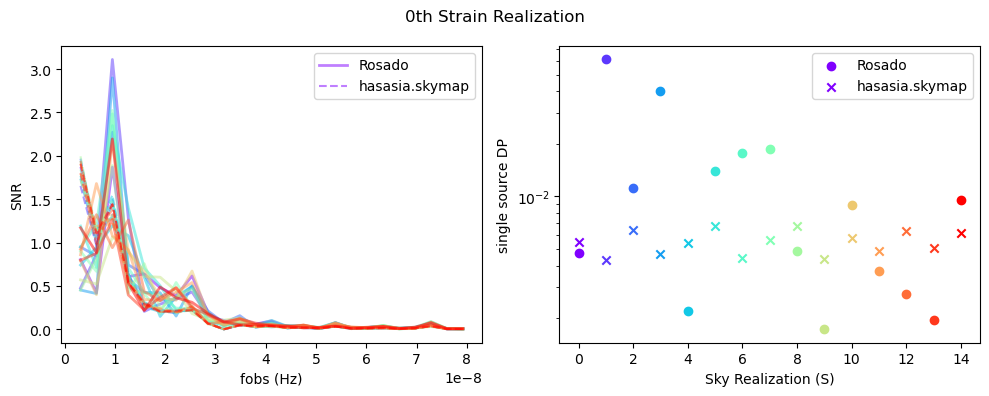

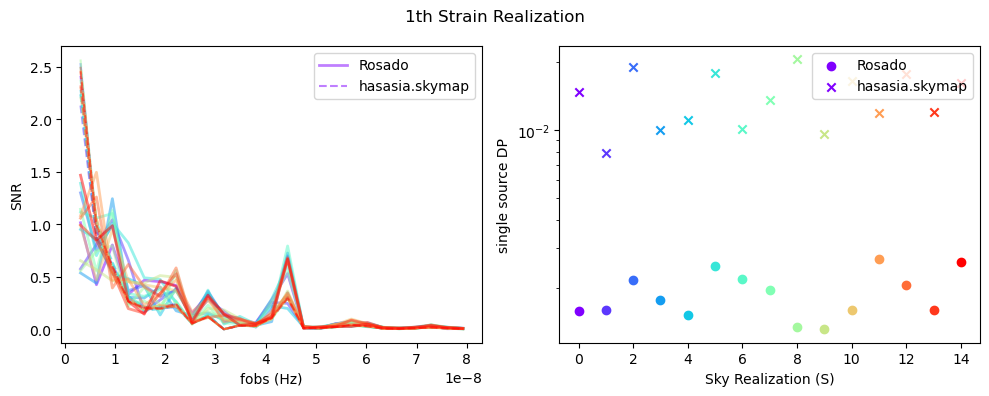

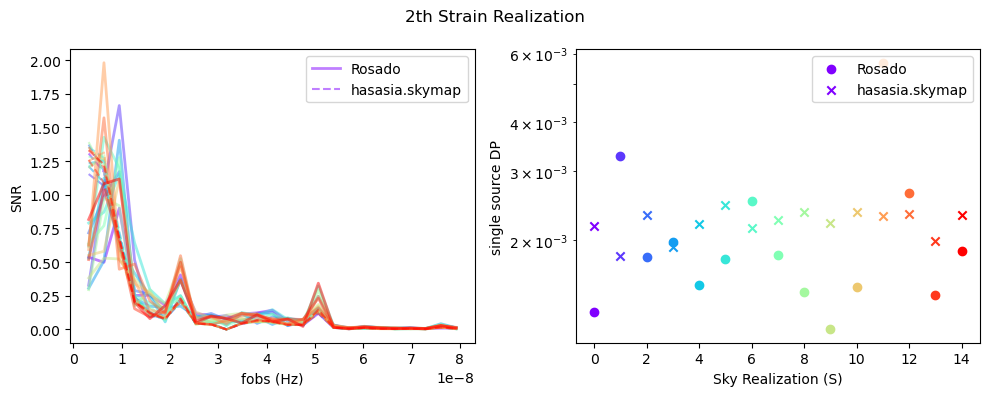

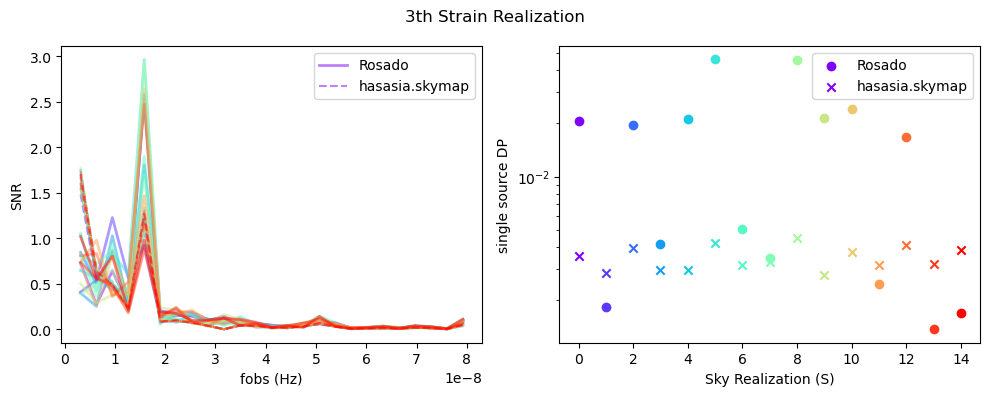

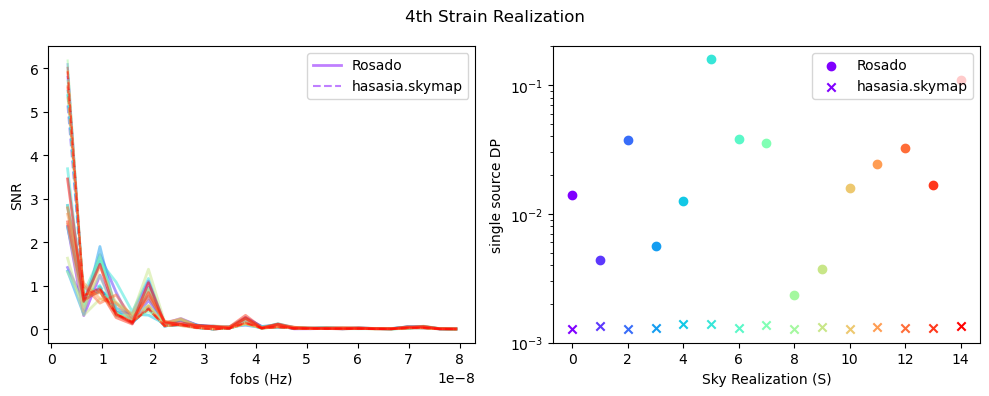

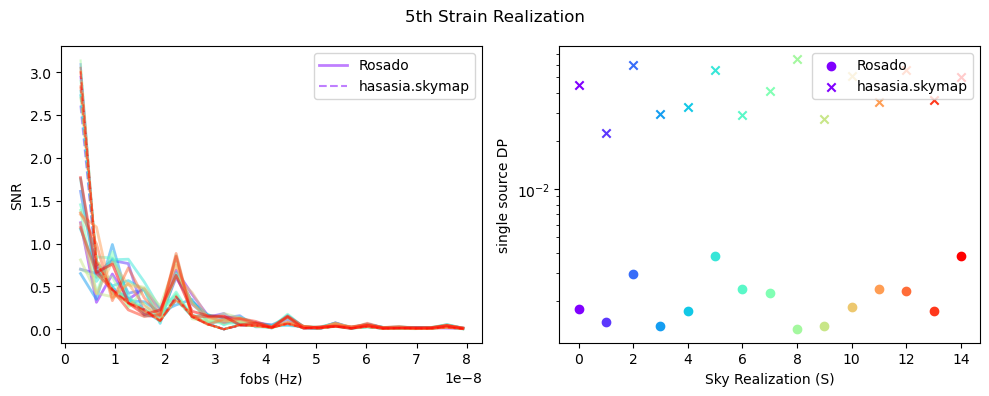

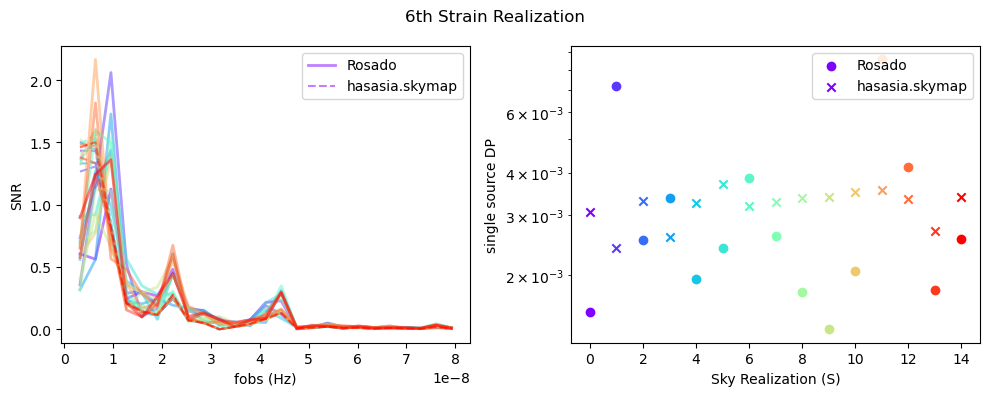

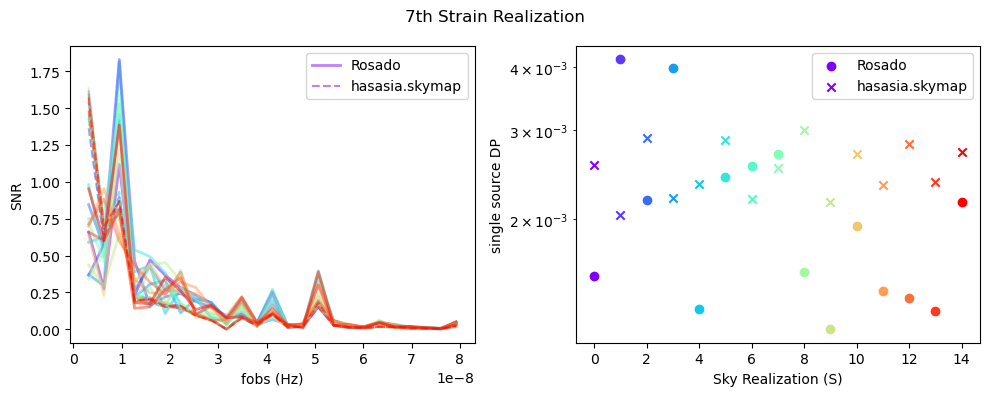

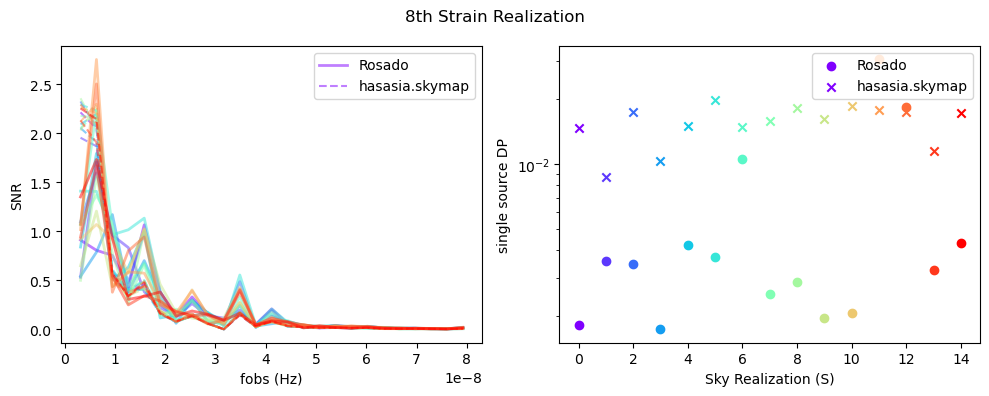

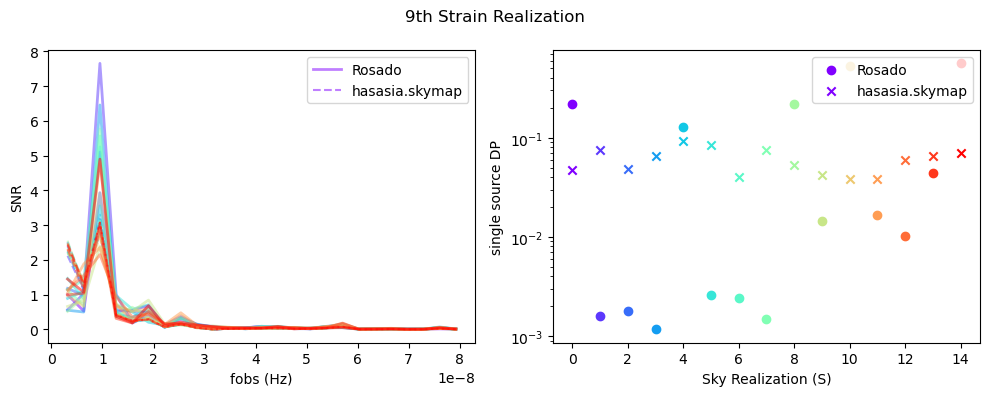

In [16]:
for rr in range(0,10):
    fig = plot_strain_real(dp_ros[:,rr], snr_ros[:,:,rr,:], dp_sky[:,rr], snr_sky[:,:,rr,:],
                        label1='Rosado', label2='hasasia.skymap', figlabel='%dth Strain Realization' %rr)

In [17]:
def plot_sky_real(DP1, SNR1, DP2, SNR2, label1='Rosado', label2='skymap(iota)', figlabel='Single Strain Realization'):
    """
    Parameters
    ----------
    DP1 : (R,) 1Darray
        Detection probability for each sky realization of a given strain realization
        by method 1 (default Rosado)
    SNR1 : (F, R, L) NDarray 
        SNR of each loudest source for each sky realization of a given strain realiztaion
        by method 1 (default Rosado)
    DP2 : (R,) 1Darray
        Detection probability for each sky realization of a given strain realization
        by method 2 (default skymap.SNR)
    SNR2 : (F, R, L) NDarray 
        SNR of each loudest source for each sky realization of a given strain realiztaion
        by method 2 (default skymap.SNR)
    label 1 : string
        label for method 1, default Rosado,
    label 2 : string
        label for method 2, default skymap(iota)

    Returns
    ------
    fig 
    
    """
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    nreals = np.min([15, len(DP1)])  # number of sky realizations to plot
    colors = cm.rainbow(np.linspace(0,1,nreals))
    rr = 0
    axs[0].plot(fobs, SNR1[:,rr,0], color=colors[rr], linestyle='-', alpha=0.5, linewidth=2, label=label1) 
    axs[0].plot(fobs, SNR2[:,rr,0], color=colors[rr], linestyle='--', alpha=0.5, label=label2)
    axs[1].scatter(rr, DP1[rr], color = colors[rr], marker='o', label=label1)
    axs[1].scatter(rr, DP2[rr], color = colors[rr], marker='x', label=label2)
    
    for rr in range(1, nreals):
        # 0th loudest
        axs[0].plot(fobs, SNR1[:,rr,0], linestyle='-', alpha=0.5, color=colors[rr], linewidth=2) 
        axs[0].plot(fobs, SNR2[:,rr,0], linestyle='--', alpha=0.5, color = colors[rr])

        axs[1].scatter(rr, DP1[rr], color = colors[rr],marker='o')
        axs[1].scatter(rr, DP2[rr], color = colors[rr], marker='x')

    axs[0].set_xlabel('fobs (Hz)')
    axs[0].set_ylabel('SNR')
    axs[0].legend()

    axs[1].set_ylabel('single source DP')
    axs[1].set_xlabel('Strain Realization (R)')
    axs[1].set_yscale('log')
    axs[1].legend(loc='upper right')

    fig.suptitle(figlabel)
    fig.tight_layout()
    return fig

## Varying strain for single sky realization plot

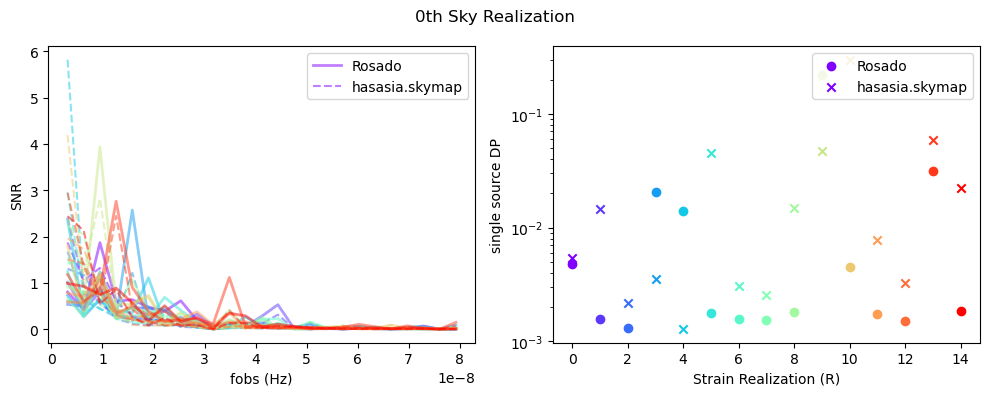

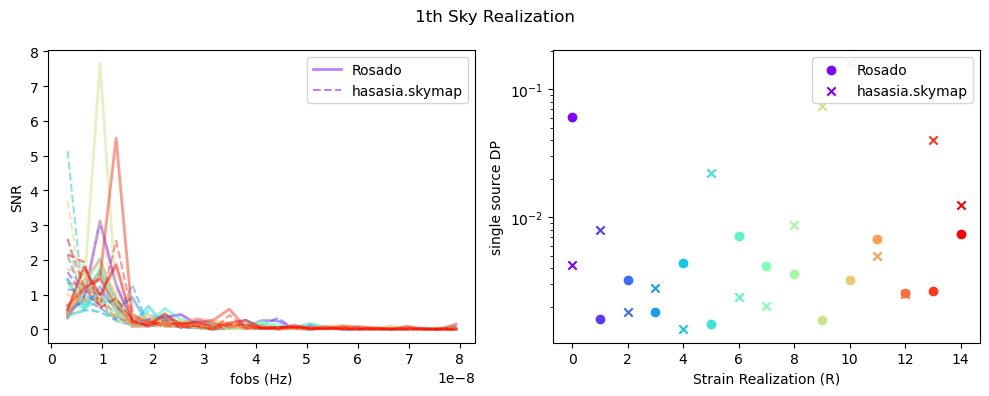

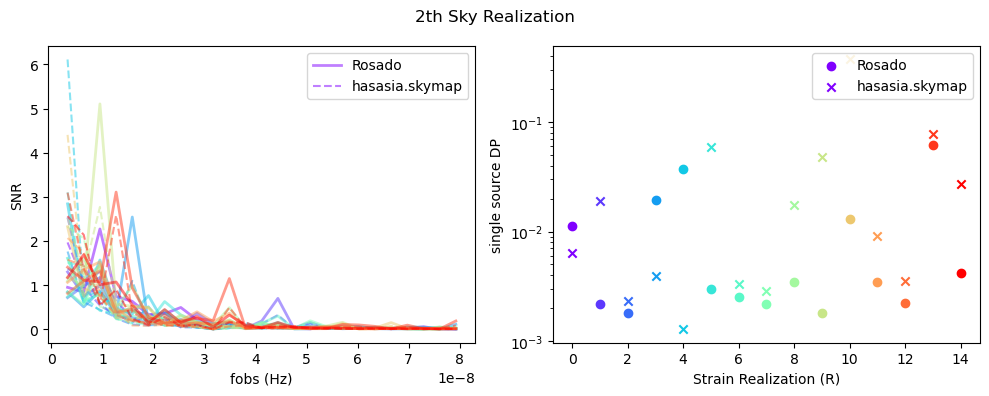

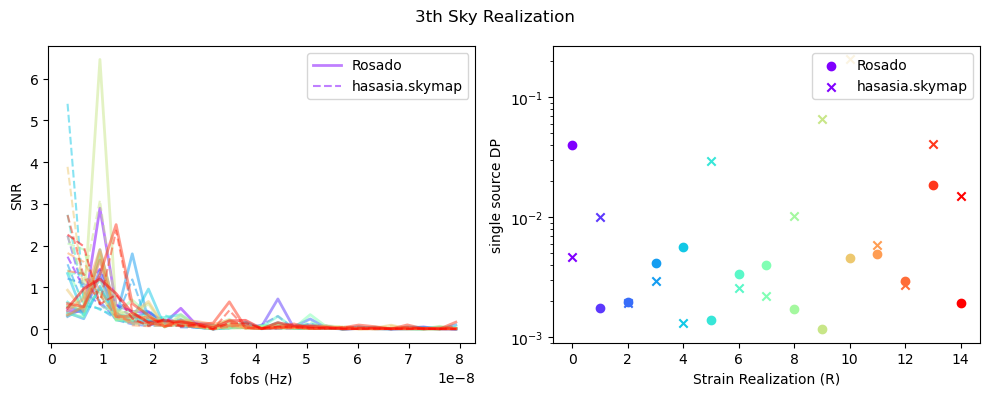

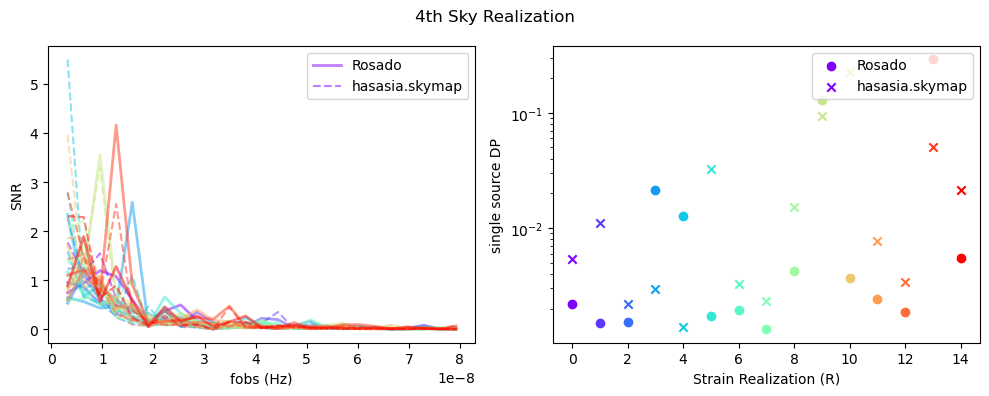

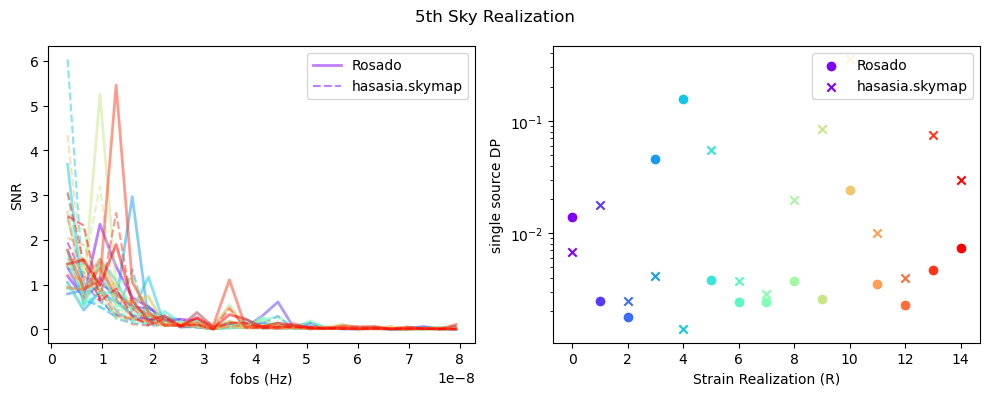

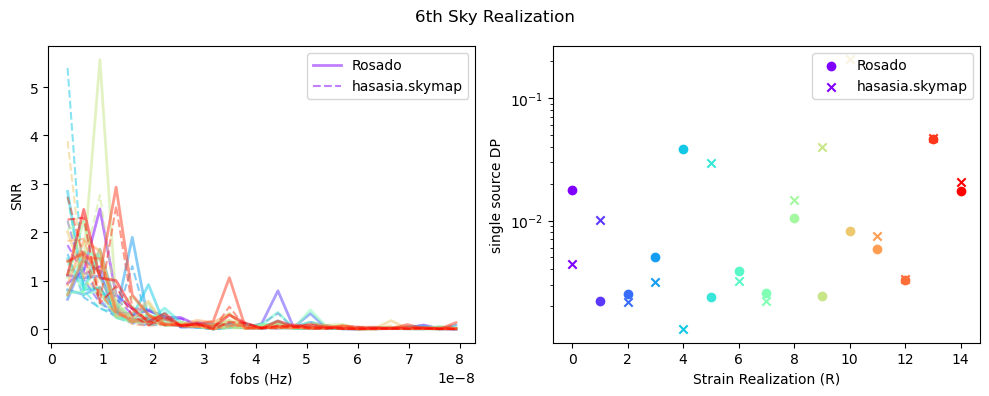

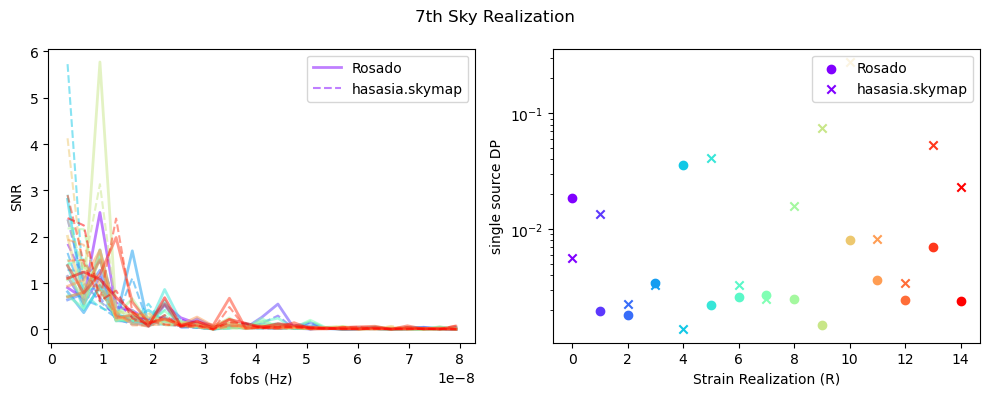

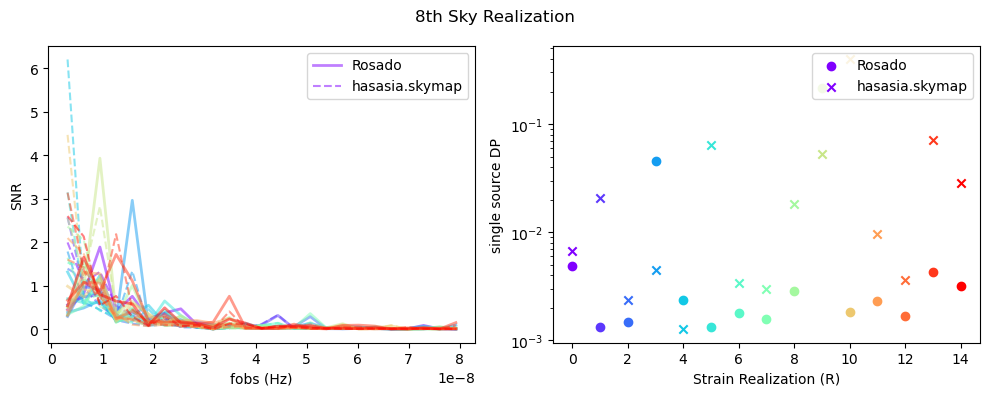

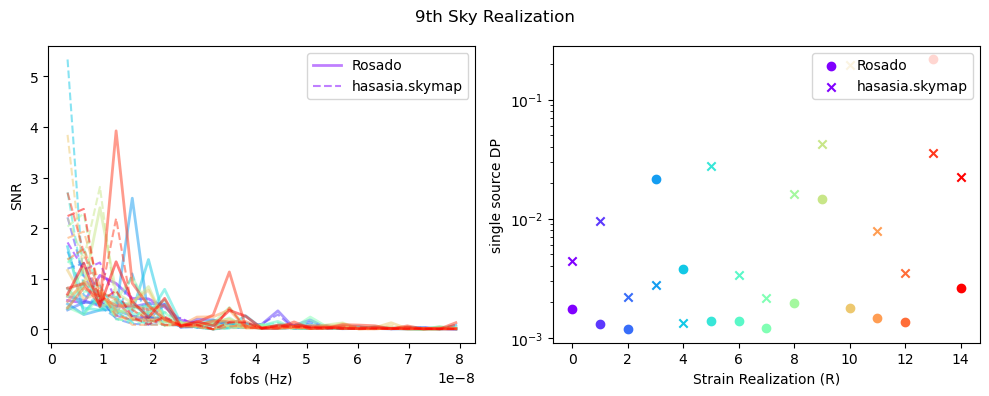

In [18]:
for ss in range(0,10):
    fig = plot_sky_real(dp_ros[ss,:], snr_ros[ss,:,:,:], dp_sky[ss,:], snr_sky[ss,:,:,:],
                        label1='Rosado', label2='hasasia.skymap', figlabel='%dth Sky Realization' %ss)

## Standard Deviation Plot

In [19]:
def plot_reals_stdev(DP1, SNR1, DP2, SNR2, label1='Rosado', label2='skymap(iota)', figlabel=None):
    """
    Parameters
    ----------
    DP1 : (S,R) NDarray
        Detection probability for each sky realization of a given strain realization
        by method 1 (default Rosado)
    SNR1 : (S, F, R, L) NDarray 
        SNR of each loudest source for each sky realization of a given strain realiztaion
        by method 1 (default Rosado)
    DP2 : (S,R) NDarray
        Detection probability for each sky realization of a given strain realization
        by method 2 (default skymap.SNR)
    SNR2 : (S, F, R, L) NDarray 
        SNR of each loudest source for each sky realization of a given strain realiztaion
        by method 2 (default skymap.SNR)
    label 1 : string
        label for method 1, default Rosado,
    label 2 : string
        label for method 2, default skymap(iota)

    Returns
    ------
    fig

    """
    fig, axs = plt.subplots(2, 2, figsize=(10,8))
    nreals = len(DP1[0])  # number of strain realizations to plot
    color1 = 'tab:purple'
    color2 = 'tab:green'
    reals = np.arange(R)
    axs[0,0].plot(reals, np.std(SNR1, axis=(0,1)), color1, marker='o', linestyle='-', linewidth=2, label=label1) 
    axs[0,0].plot(reals, np.std(SNR2, axis=(0,1)), color2, marker='x', linestyle='--', label=label2)
    axs[0,1].plot(reals, np.std(DP1, axis=0), color = color1, marker='o', label=label1)
    axs[0,1].plot(reals, np.std(DP2, axis=0), color = color2, marker='x', label=label2)
    
    # for rr in range(1, nreals):
    #     axs[0,0].plot(reals, np.std(SNR1, axis=(0,1)), color=colors[rr], marker='o', linestyle='-', alpha=0.5, linewidth=2) 
    #     axs[0,0].plot(reals, np.std(SNR2, axis=(0,1)), color=colors[rr], marker='x', linestyle='--', alpha=0.5)
    #     axs[0,1].plot(rr, np.std(DP1, axis=0), color = colors[rr], marker='o')
    #     axs[0,1].plot(rr, np.std(DP2, axis=0), color = colors[rr], marker='x')
    
    axs[0,0].set_xlabel('Strain Realization (R)')
    axs[0,0].set_ylabel('stdev(SNR) over sky reals, S')
    axs[0,0].legend(loc='upper right')

    axs[0,1].set_xlabel('Strain Realization (R)')
    axs[0,1].set_ylabel('stdev(DP) over sky reals, S')
    axs[0,1].legend(loc='upper right')

    skies = np.arange(S)
    axs[1,0].plot(skies, np.std(SNR1, axis=(1,2)), color=color1, marker='o', linestyle='-', linewidth=2, label=label1) 
    axs[1,0].plot(skies, np.std(SNR2, axis=(1,2)), color=color2, marker='x', linestyle='--', label=label2)
    axs[1,1].plot(skies, np.std(DP1, axis=1), color = color1, marker='o', label=label1)
    axs[1,1].plot(skies, np.std(DP2, axis=1), color = color2, marker='x', label=label2)
    
    # for rr in range(1, nreals):
    #     axs[1,0].plot(rr, np.std(SNR1, axis=(1,2)), color=colors[rr], marker='o', linestyle='-', alpha=0.5, linewidth=2) 
    #     axs[1,0].plot(rr, np.std(SNR2, axis=(1,2)), color=colors[rr], marker='x', linestyle='--', alpha=0.5)
    #     axs[1,1].plot(rr, np.std(DP1, axis=1), color = colors[rr], marker='o')
    #     axs[1,1].plot(rr, np.std(DP2, axis=1), color = colors[rr], marker='x')
    
    axs[1,0].set_xlabel('Sky Realization (S)')
    axs[1,0].set_ylabel('stdev(SNR) over strain reals, R')
    axs[1,0].legend(loc='upper right')

    axs[1,1].set_xlabel('Sky Realization (S)')
    axs[1,1].set_ylabel('stdev(DP) over strain reals, R')
    axs[1,1].legend(loc='upper right')

    if figlabel is not None:
        fig.suptitle(figlabel)
    fig.tight_layout()
    return fig
    
    

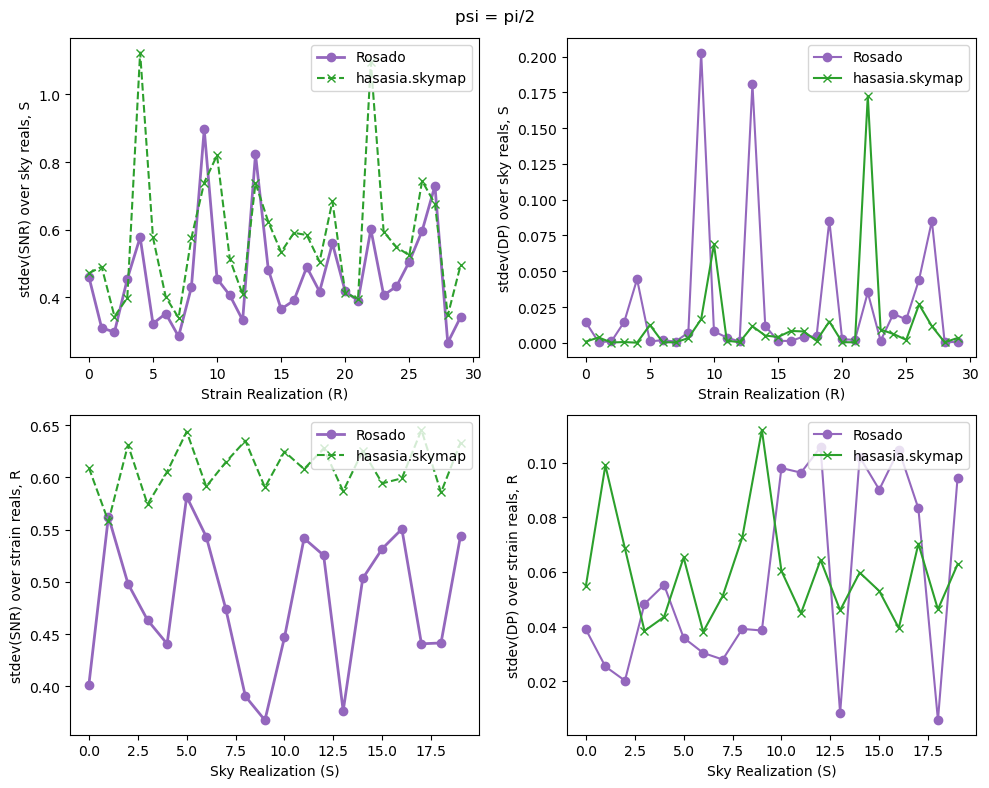

In [20]:
fig = plot_reals_stdev(dp_ros, snr_ros, dp_sky, snr_sky,
                       label1='Rosado', label2='hasasia.skymap', figlabel=psi_label)